In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, Flatten, Bidirectional
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

from sklearn.model_selection import GridSearchCV
import itertools

In [ ]:
# Download stopwords for further processing
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#columns = ['target', 'id', 'date', 'flag', 'user', 'text']
movie_data = pd.read_csv("/content/IMDB Dataset.csv")

In [ ]:
movie_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# Lowercasing
movie_data['review'] = movie_data['review'].apply(lambda x: x.lower())

In [ ]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and numbers
    text = re.sub(r'\@\w+|\#|\d+', '', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    return text

movie_data['review'] = movie_data['review'].apply(clean_text)

In [ ]:
movie_data['review'] = movie_data['review'].apply(word_tokenize)


In [ ]:
movie_data['sentiment'].replace("positive", 1, inplace=True)
movie_data['sentiment'].replace("negative", 0, inplace=True)

<ipython-input-8-f9339c7357ac>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movie_data['sentiment'].replace("positive", 1, inplace=True)
<ipython-input-8-f9339c7357ac>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

In [ ]:
value_counts = movie_data['sentiment'].value_counts()
print(value_counts)

sentiment
1    25000
0    25000
Name: count, dtype: int64


In [ ]:
stop_words = set(stopwords.words('english'))

movie_data['review'] = movie_data['review'].apply(lambda x: [word for word in x if word not in stop_words])


In [ ]:
# Define the tokenizer with a vocabulary size (e.g., 10000)
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(movie_data['review'])
word_index = tokenizer.word_index
# Convert the text to sequences of integers
sequences = tokenizer.texts_to_sequences(movie_data['review'])

# Pad the sequences so they all have the same length
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

In [ ]:
# Load the GloVe embeddings
embedding_index = {}
with open("/content/glove.6B.50d.txt", "r", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create an embedding matrix
embedding_dim = 50
embedding_matrix = np.zeros((10000, embedding_dim))
for word, i in word_index.items():
    if i < 10000:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
# Convert labels to numpy array
labels = np.array(movie_data['sentiment'])

# Split the data into training, validation and test sets
train_padded, val_padded, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2)
val_padded, test_padded, val_labels, test_labels = train_test_split(val_padded, val_labels, test_size=0.2)

In [ ]:
print(f"Training set: {len(train_padded)}")
print(f"Validation set: {len(val_padded)}")
print(f"Test set: {len(test_padded)}")

Training set: 40000
Validation set: 8000
Test set: 2000


In [ ]:
def grid_search(X_train, y_train, X_val, y_val, param_grid, create_nn):
    # Generate all combinations of hyperparameters
    param_combinations = list(itertools.product(
        param_grid['neurons'],
        param_grid['learning_rate'],
        param_grid['dropout_rate'],
        param_grid['batch_size'],
        param_grid['epochs']
    ))

    best_score = 0
    best_params = None
    best_model = None
    best_history = None

    # Iterate over all combinations
    for neurons, learning_rate, dropout_rate, batch_size, epochs in param_combinations:
        # Create and train the model
        model = create_nn(neurons=neurons, learning_rate=learning_rate, dropout_rate=dropout_rate)

        # Set up EarlyStopping
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )

        # Fit the model
        history = model.fit(
            X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=0,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping]
        )

        # Evaluate the model on the validation set
        val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)

        print(f"Parameters: neurons={neurons}, learning_rate={learning_rate}, dropout_rate={dropout_rate}, batch_size={batch_size}, epochs={epochs}")
        print(f"Validation Accuracy: {val_accuracy}")

        # Save the best model based on validation accuracy
        if val_accuracy > best_score:
            best_score = val_accuracy
            best_params = {
                'neurons': neurons,
                'learning_rate': learning_rate,
                'dropout_rate': dropout_rate,
                'batch_size': batch_size,
                'epochs': epochs
            }
            best_model = model
            best_history = history

    print("Best parameters found: ", best_params)
    print("Best validation accuracy: ", best_score)

    return best_model, best_history

# **################################################**

# **PLAIN NN**

In [ ]:
def create_nn(neurons=64, learning_rate=0.001, dropout_rate=0.5):
    model_nn = tf.keras.Sequential()
    model_nn.add(Embedding(input_dim=10000, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False))
    model_nn.add(Flatten())
    model_nn.add(Dense(neurons, activation='relu'))
    model_nn.add(Dropout(dropout_rate))
    model_nn.add(Dense(neurons, activation='relu'))
    model_nn.add(Dropout(dropout_rate))
    model_nn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model_nn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model_nn


In [ ]:
def plot_history(history, save_path):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend(['Train', 'Validation'])

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

# **You can avoid executing the cells below, as the optimal model for the NN is alredy provided.**

In [ ]:
param_grid = {
    'batch_size': [32, 64],
    'epochs': [10, 20, 30],
    'neurons': [16, 32, 64, 128],  # Tuning the number of neurons in the LSTM layer
    'learning_rate': [0.01, 0.001, 0.0001],  # Tuning the learning rate
    'dropout_rate': [0.0, 0.3, 0.6, 0.9]  # Tuning the dropout rate
}

In [ ]:
best_model, best_history = grid_search(train_padded, train_labels, val_padded, val_labels, param_grid, create_nn)

# Save plots for the best model
plot_history(best_history, 'best_model_training_history.png')

Parameters: neurons=16, learning_rate=0.01, dropout_rate=0.0, batch_size=32, epochs=10
Validation Accuracy: 0.7236250042915344
Parameters: neurons=16, learning_rate=0.01, dropout_rate=0.0, batch_size=32, epochs=20
Validation Accuracy: 0.7208750247955322
Parameters: neurons=16, learning_rate=0.01, dropout_rate=0.0, batch_size=32, epochs=30
Validation Accuracy: 0.7211250066757202
Parameters: neurons=16, learning_rate=0.01, dropout_rate=0.0, batch_size=64, epochs=10
Validation Accuracy: 0.7227500081062317
Parameters: neurons=16, learning_rate=0.01, dropout_rate=0.0, batch_size=64, epochs=20
Validation Accuracy: 0.7282500267028809
Parameters: neurons=16, learning_rate=0.01, dropout_rate=0.0, batch_size=64, epochs=30
Validation Accuracy: 0.7213749885559082
Parameters: neurons=16, learning_rate=0.01, dropout_rate=0.3, batch_size=32, epochs=10
Validation Accuracy: 0.5062500238418579
Parameters: neurons=16, learning_rate=0.01, dropout_rate=0.3, batch_size=32, epochs=20
Validation Accuracy: 0.7

KeyboardInterrupt: 

In [ ]:
model_nn = create_nn(128, 0.001, 0.6)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5607 - loss: 0.6965 - val_accuracy: 0.6998 - val_loss: 0.5918
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6640 - loss: 0.6010 - val_accuracy: 0.7199 - val_loss: 0.5695
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7032 - loss: 0.5568 - val_accuracy: 0.7225 - val_loss: 0.5687
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7174 - loss: 0.5377 - val_accuracy: 0.7243 - val_loss: 0.5617
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7302 - loss: 0.5226 - val_accuracy: 0.7234 - val_loss: 0.5559
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7330 - loss: 0.5115 - val_accuracy: 0.7270 - val_loss: 0.5494
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7410 - loss: 0.4980 - val_accuracy: 0.7222 - val_loss: 0.5483
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7468 - loss: 0.4834 - val_accuracy: 0

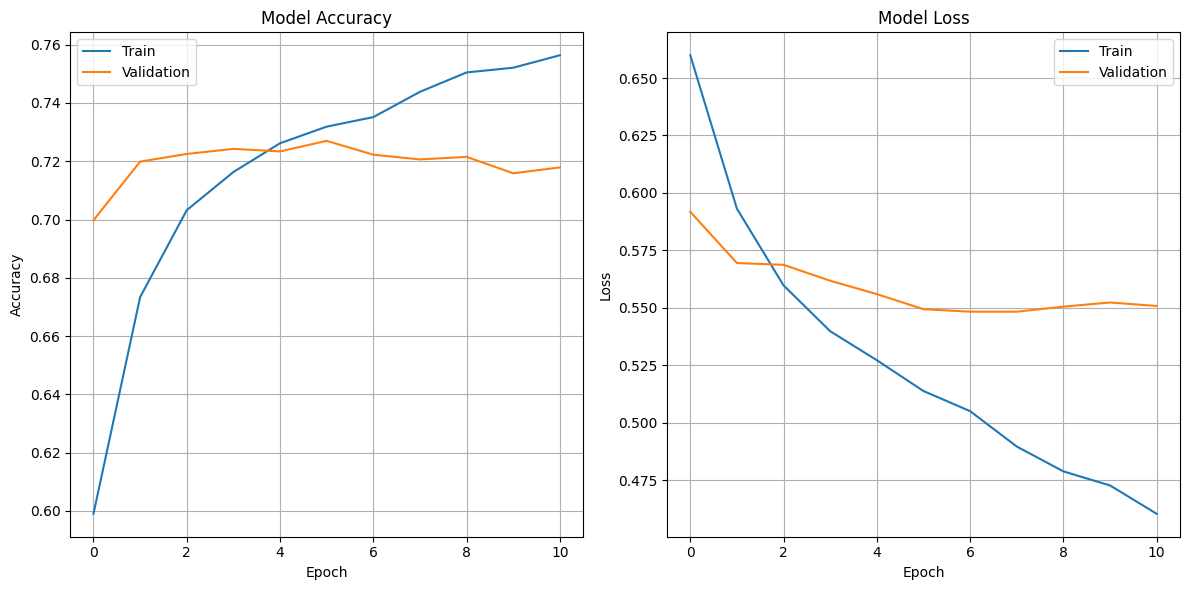

In [ ]:
early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
history_nn = model_nn.fit(train_padded, train_labels,
                          epochs=20,
                          batch_size=64,
                          validation_data=(val_padded, val_labels),
                          callbacks = [early_stopping])

plot_history(history_nn, 'best_nn_model_training_history.png')

In [ ]:
val_loss, val_accuracy = model_nn.evaluate(val_padded, val_labels, verbose=0)
print(f"Validation Accuracy: {val_accuracy}")

Validation Accuracy: 0.7206249833106995


In [ ]:
model_nn.save('model_nn.h5')
model_nn.save('model_nn.keras')

# **Load the model**

In [ ]:
model_nn = load_model("model_nn.keras")

In [ ]:
y_pred_probs = model_nn.predict(test_padded)
y_pred = np.round(y_pred_probs)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(test_labels, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1003
           1       0.84      0.83      0.84       997

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



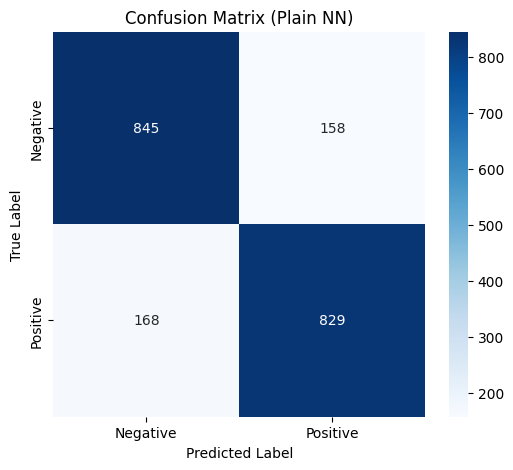

In [ ]:
import seaborn as sns

cm = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Plain NN)")
plt.show()

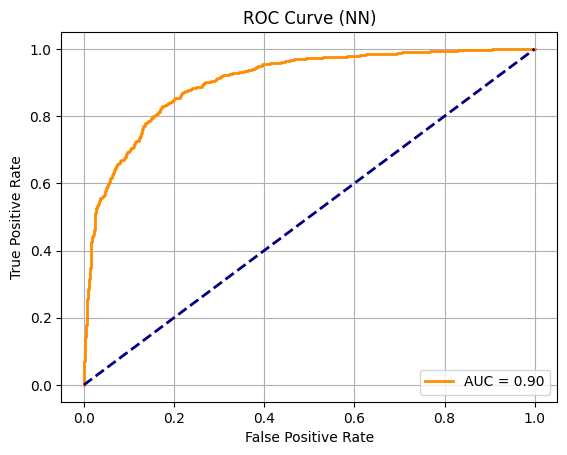

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(test_labels, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.title("ROC Curve (NN)")
plt.legend(loc="lower right")
plt.show()

# **##########################################**

# **LSTM**

In [ ]:
def create_lstm(neurons=64, learning_rate=0.001, dropout_rate = 0.5, l2_rate=0.5):
# Assuming your input data is tokenized and padded (train_padded, val_padded, etc.)
  model_lstm = tf.keras.Sequential()

# Embedding layer (optional if using pre-trained embeddings)
  model_lstm.add(Embedding(input_dim=10000, output_dim=50, weights=[embedding_matrix], trainable=False))

# LSTM layer
  model_lstm.add(LSTM(neurons, kernel_regularizer=regularizers.l2(l2_rate)))  # 64 units for LSTM, you can adjust this value

# Dropout for regularization
  model_lstm.add(Dropout(dropout_rate))

# Output layer for binary classification
  model_lstm.add(Dense(1, activation='sigmoid'))

  optimizer = Adam(learning_rate=learning_rate)

# Compile the model
  model_lstm.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  return model_lstm

# **You can avoid executing the cells below, as the optimal model for the LSTM is alredy provided.**

In [ ]:
param_grid = {
    'batch_size': [32, 64],
    'epochs': [50, 100, 150],
    'neurons': [16, 32, 64],  # Tuning the number of neurons in the LSTM layer
    'learning_rate': [0.01, 0.001],  # Tuning the learning rate
    'dropout_rate': [0.0, 0.5],  # Tuning the dropout rate
    'l2_rate': [0.0, 0.01, 0.001]
}

In [ ]:
best_model, best_history = grid_search(train_padded, train_labels, val_padded, val_labels, param_grid, create_lstm)

# Save plots for the best model
plot_history(best_history, 'best_lstm_model_training_history.png')

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.6396 - loss: 0.6661 - val_accuracy: 0.7582 - val_loss: 0.5280
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.7749 - loss: 0.5079 - val_accuracy: 0.7864 - val_loss: 0.4852
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.7957 - loss: 0.4672 - val_accuracy: 0.7837 - val_loss: 0.4759
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.8080 - loss: 0.4448 - val_accuracy: 0.7929 - val_loss: 0.4620
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.8156 - loss: 0.4313 - val_accuracy: 0.7993 - val_loss: 0.4473
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.8179 - loss: 0.4310 - val_accuracy: 0.8069 - val_loss: 0.4353
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.8196 - loss: 0.4246 - val_accuracy: 0.8052 - val_loss: 0.4560
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.8247 - loss: 0.4139 - 

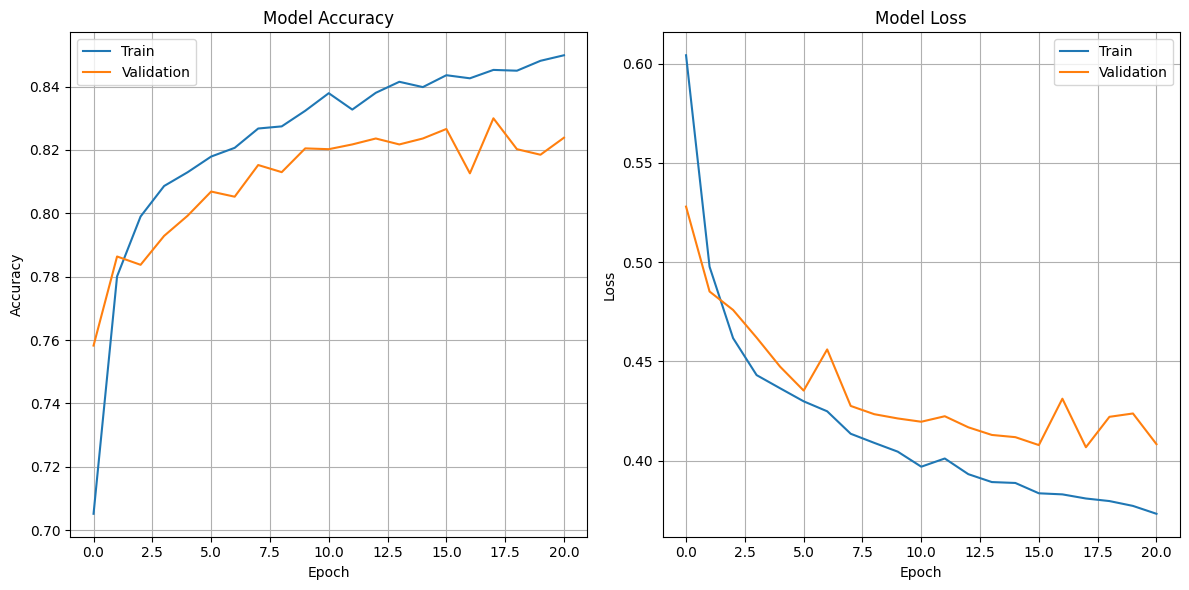

In [ ]:
model_lstm = create_lstm(32, 0.001, 0.0, 0.001)

early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
history_nn = model_lstm.fit(train_padded, train_labels,
                          epochs=50,
                          batch_size=64,
                          validation_data=(val_padded, val_labels),
                          callbacks = [early_stopping])

plot_history(history_nn, 'best_lstm_model_training_history.png')

In [ ]:
val_loss, val_accuracy = model_lstm.evaluate(val_padded, val_labels, verbose=0)
print(f"Validation Accuracy: {val_accuracy}")

Validation Accuracy: 0.8299999833106995


In [ ]:
model_lstm.save('model_lstm.h5')
model_lstm.save('model_lstm.keras')

# **Load the model**

In [ ]:
model_lstm = load_model("model_lstm.keras")

In [ ]:
y_pred_probs = model_lstm.predict(test_padded)
y_pred = np.round(y_pred_probs)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
print("Classification Report:")
print(classification_report(test_labels, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1003
           1       0.82      0.84      0.83       997

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



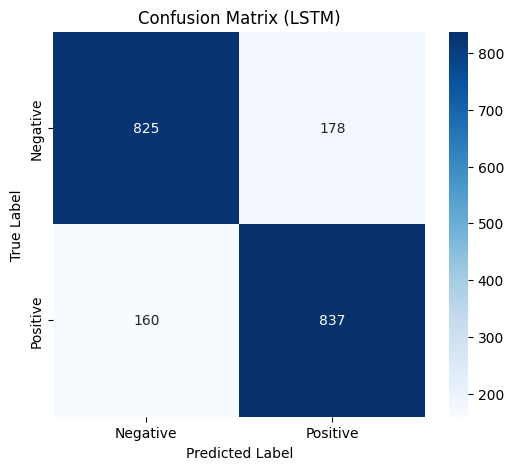

In [ ]:
cm = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (LSTM)")
plt.show()

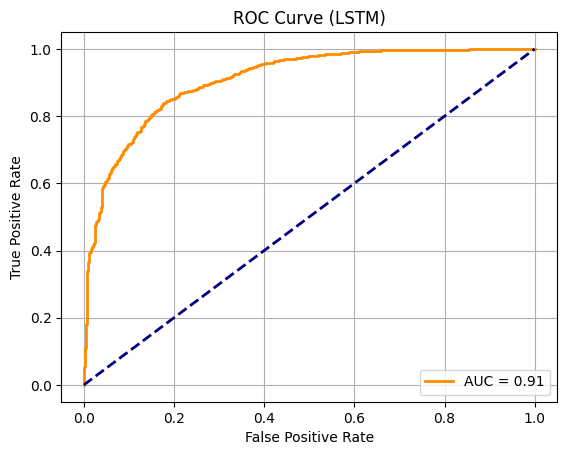

In [ ]:
fpr, tpr, _ = roc_curve(test_labels, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.title("ROC Curve (LSTM)")
plt.legend(loc="lower right")
plt.show()

# **###########################**

# **LSTM BIDIRECTIONAL**

In [ ]:
def create_lstm_bi(neurons=64, learning_rate=0.001, dropout_rate=0.5, l2_rate = 0.01):
  model_lstm_bi = tf.keras.Sequential()

# Embedding layer (optional if using pre-trained embeddings)
  model_lstm_bi.add(Embedding(input_dim=10000, output_dim=50, weights=[embedding_matrix], trainable=False))

# LSTM layer
  model_lstm_bi.add(Bidirectional(LSTM(neurons, kernel_regularizer=regularizers.l2(l2_rate))))  # 64 units for LSTM, you can adjust this value

# Dropout for regularization
  model_lstm_bi.add(Dropout(dropout_rate))

# Output layer for binary classification
  model_lstm_bi.add(Dense(1, activation='sigmoid'))
  optimizer = Adam(learning_rate=learning_rate)

# Compile the model
  model_lstm_bi.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

  return model_lstm_bi

# **You can avoid executing the cells below, as the optimal model for the bi-directional LSTM is alredy provided.**

In [ ]:
param_grid = {
    'batch_size': [32, 64],
    'epochs': [50, 100, 150],
    'neurons': [16, 32, 64],  # Tuning the number of neurons in the LSTM layer
    'learning_rate': [0.01, 0.001],  # Tuning the learning rate
    'dropout_rate': [0.0, 0.5],  # Tuning the dropout rate
    'l2_rate': [0.0, 0.01, 0.001]
}

In [ ]:
best_model, best_history = grid_search(train_padded, train_labels, val_padded, val_labels, param_grid, create_lstm_bi)

# Save plots for the best model
plot_history(best_history, 'best_model_training_history.png')

Parameters: neurons=16, learning_rate=0.01, dropout_rate=0.0, batch_size=32, epochs=50
Validation Accuracy: 0.797249972820282
Parameters: neurons=16, learning_rate=0.01, dropout_rate=0.0, batch_size=32, epochs=100
Validation Accuracy: 0.7951250076293945
Parameters: neurons=16, learning_rate=0.01, dropout_rate=0.0, batch_size=32, epochs=150
Validation Accuracy: 0.7956249713897705
Parameters: neurons=16, learning_rate=0.01, dropout_rate=0.0, batch_size=64, epochs=50
Validation Accuracy: 0.8003749847412109
Parameters: neurons=16, learning_rate=0.01, dropout_rate=0.0, batch_size=64, epochs=100
Validation Accuracy: 0.7991250157356262
Parameters: neurons=16, learning_rate=0.01, dropout_rate=0.0, batch_size=64, epochs=150
Validation Accuracy: 0.8002499938011169
Parameters: neurons=16, learning_rate=0.01, dropout_rate=0.5, batch_size=32, epochs=50
Validation Accuracy: 0.7885000109672546
Parameters: neurons=16, learning_rate=0.01, dropout_rate=0.5, batch_size=32, epochs=100
Validation Accuracy:

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 131s 206ms/step - accuracy: 0.6903 - loss: 0.6496 - val_accuracy: 0.7505 - val_loss: 0.5287
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 208ms/step - accuracy: 0.7751 - loss: 0.5037 - val_accuracy: 0.7878 - val_loss: 0.4755
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 206ms/step - accuracy: 0.8011 - loss: 0.4615 - val_accuracy: 0.7881 - val_loss: 0.4653
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 210ms/step - accuracy: 0.8103 - loss: 0.4424 - val_accuracy: 0.8004 - val_loss: 0.4572
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 208ms/step - accuracy: 0.8158 - loss: 0.4331 - val_accuracy: 0.8005 - val_loss: 0.4408
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 210ms/step - accuracy: 0.8238 - loss: 0.4153 - val_accuracy: 0.8126 - val_loss: 0.4311
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 130s 208ms/step - accuracy: 0.8230 - loss: 0.4150 - val_accuracy: 0.8046 - val_loss: 0.4313
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 206ms/step - accuracy: 0.8287 -

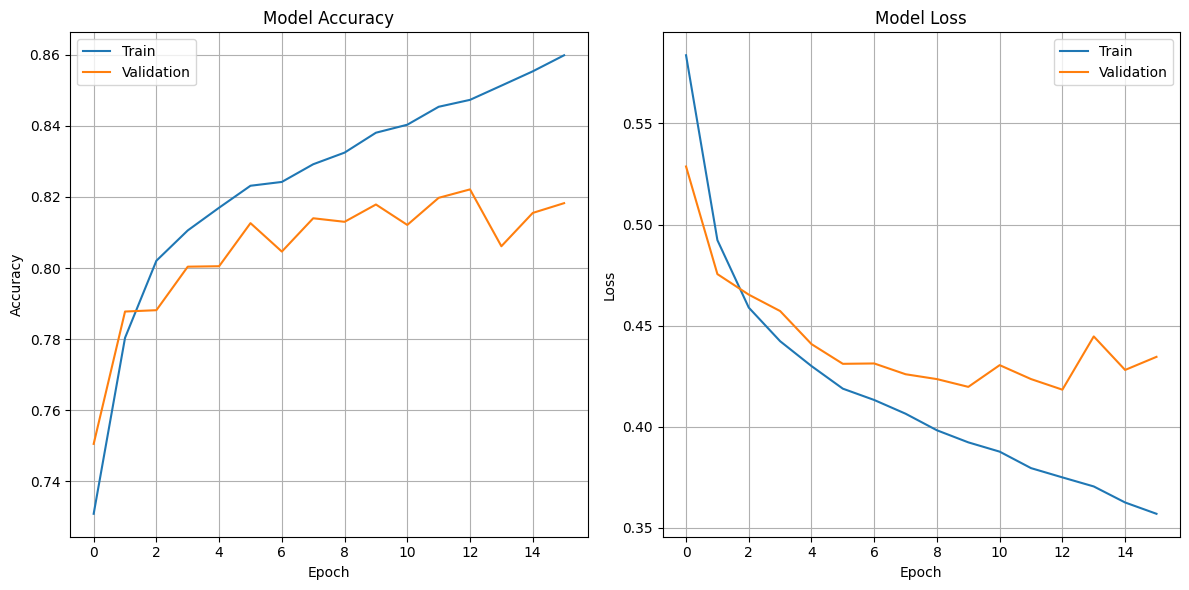

In [ ]:
model_lstm_bi = model_nn = create_lstm_bi(128, 0.001, 0.0, 0.001)
early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
history_nn = model_lstm_bi.fit(train_padded, train_labels,
                          epochs=50,
                          batch_size=64,
                          validation_data=(val_padded, val_labels),
                          callbacks = [early_stopping])

plot_history(history_nn, 'best_bilstm_model_training_history.png')

In [ ]:
val_loss, val_accuracy = model_lstm_bi.evaluate(val_padded, val_labels, verbose=0)
print(f"Validation Accuracy: {val_accuracy}")

Validation Accuracy: 0.8221250176429749


In [ ]:
model_lstm_bi.save('model_lstm_bi.h5')
model_lstm_bi.save('model_lstm_bi.keras')

# **Load the model**

In [ ]:
model_lstm_bi = load_model("model_lstm_bi.keras")

In [ ]:
y_pred_probs = model_lstm_bi.predict(test_padded)
y_pred = np.round(y_pred_probs)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step


In [ ]:
print("Classification Report:")
print(classification_report(test_labels, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1003
           1       0.83      0.82      0.82       997

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



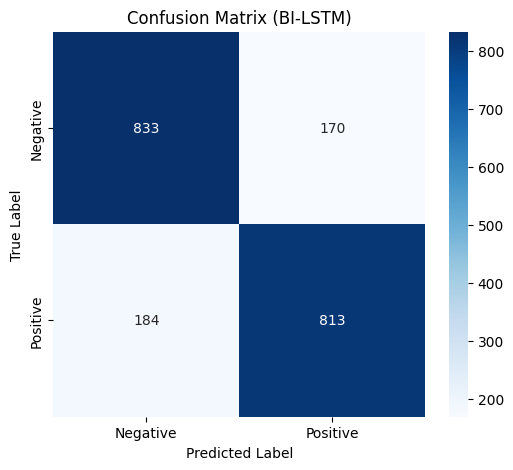

In [ ]:
cm = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (BI-LSTM)")
plt.show()

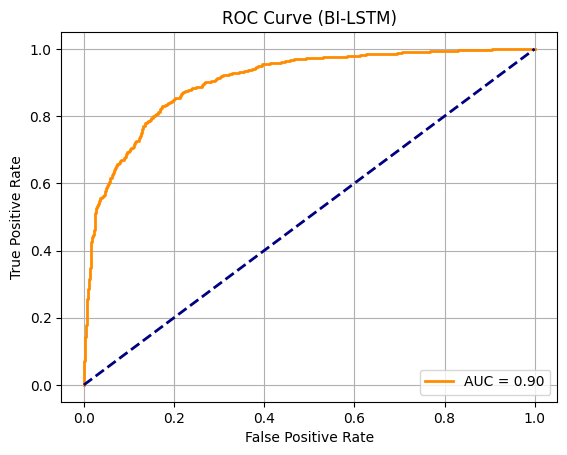

In [ ]:
fpr, tpr, _ = roc_curve(test_labels, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.title("ROC Curve (BI-LSTM)")
plt.legend(loc="lower right")
plt.show()